In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Analysis
Checking for null values, relation between different features

In [4]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Showing Corelation between different numerical features 

In [6]:
data[[i for i in data.columns\
      if data[i].dtypes in ['int64', 'float64', 'int32', 'float32']]]\
        .corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<Axes: xlabel='Survived', ylabel='count'>

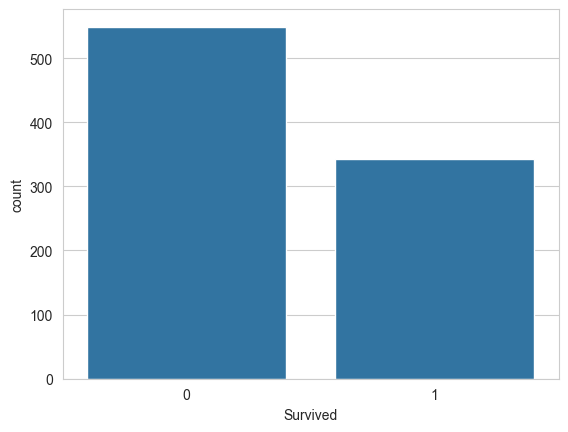

In [7]:
sb.set_style(style = 'whitegrid')
sb.countplot(data, x = 'Survived')

<Axes: xlabel='Survived', ylabel='count'>

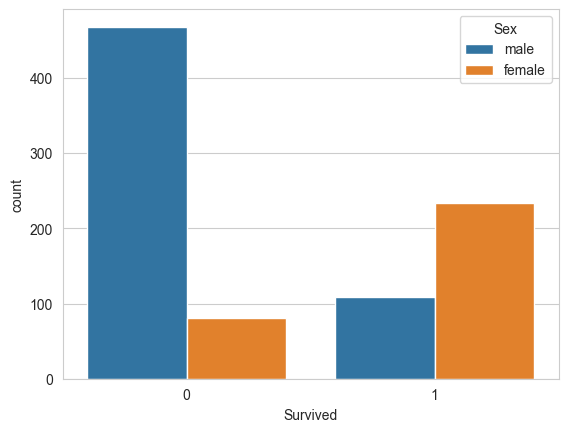

In [8]:
sb.countplot(data, x = 'Survived', hue = 'Sex')

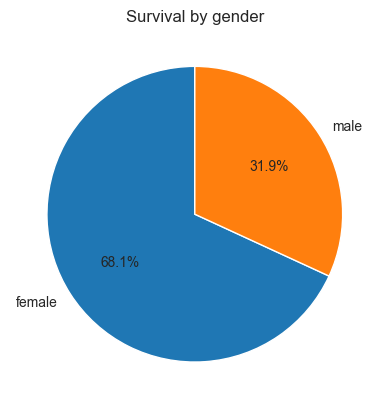

In [9]:
survived = data[data['Survived'] == 1]
survival_by_gender = survived.groupby('Sex').size()

fig, ax = plt.subplots()
ax.pie(survival_by_gender, startangle=90, autopct='%1.1f%%', labels = survival_by_gender.index)

plt.title("Survival by gender")
plt.show()

<Axes: xlabel='Survived', ylabel='count'>

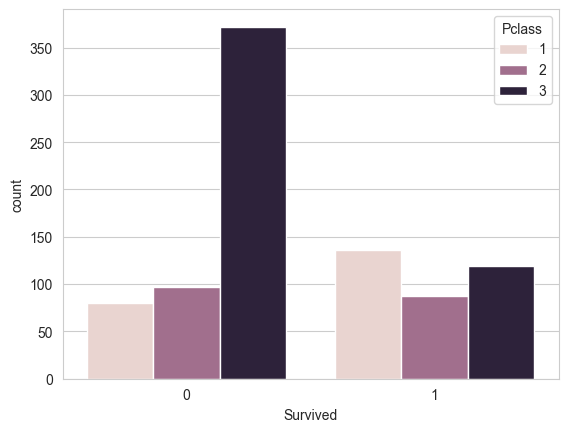

In [10]:
sb.countplot(data, x = 'Survived', hue = 'Pclass')

<Axes: xlabel='Age', ylabel='Count'>

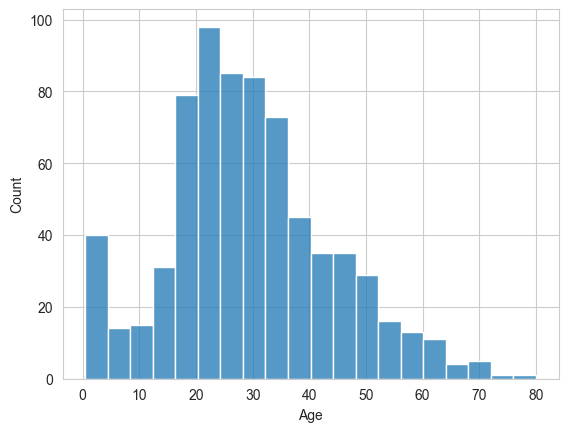

In [11]:
sb.histplot(data['Age'])

In [12]:
agg_data = survived.groupby('Survived').agg({'Age':'mean', 'Parch':'mean', 'SibSp':'mean', 'Fare':'mean', 'Pclass':lambda x : x.mode()[0]})

agg_data

,Age,Parch,SibSp,Fare,Pclass
Survived,,,,,
1,28.34369,0.464912,0.473684,48.395408,1


Most passenger who survived are from 1st class.

The average age of survived passengers is 28.

The avg fare payed by survivors > the average fare payed by everyone

<Axes: xlabel='Pclass', ylabel='Age'>

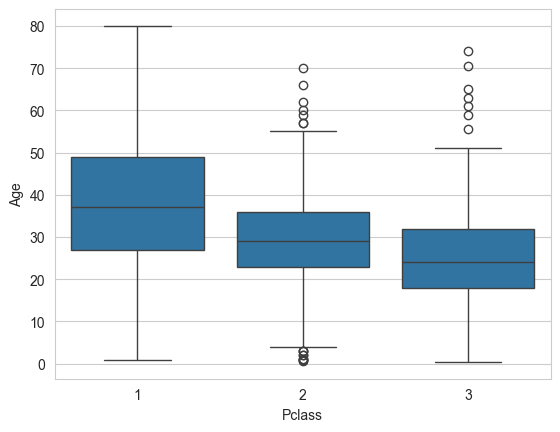

In [13]:
sb.boxplot(data, x = 'Pclass', y = 'Age')

Checking for relation between Passenger class and Age which will help us to fill null age values.
As we can clearly see the median age of passenger travelling in class 1, 2 and 3 is 37, 29 and 24 respectively, we will fill null age values respective to their Pclass.

Preprocessing data by converting Categorical features into numerical features and removing unnecessary features

In [33]:
def infer_marital_status(title):
    if title in ['Mr', 'Mrs']:
        return 1
    elif title in ['Miss', 'Master']:
        return 0
    else:
        return 2

In [15]:
def preprocess_data(data):
    le = LabelEncoder()
    data['Sex'] = le.fit_transform(data['Sex'])
    data['Embarked'] = le.fit_transform(data['Embarked'])
    data['Relatives'] = data['SibSp'] + data['Parch']
    # Dropping name, ticket, passengerId as they are unique and Cabin because most of its values are null
    data.drop(['Name', 'Ticket', 'PassengerId', 'Cabin', 'SibSp', 'Parch', 'title'], axis=1, inplace=True)
    return data

Filling null age values by using relation between Pclass and age shown above

In [16]:
def fill_null_values(cols):
    age = cols[0]
    Pclass = cols[1]

    if pd.isnull(age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return age

In [17]:
data['title'] = data['Name'].str.extract(r',\s*([A-Za-z]+)\.', expand=False)
data['title'].value_counts()

title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Don           1
Mme           1
Ms            1
Lady          1
Sir           1
Capt          1
Jonkheer      1
Name: count, dtype: int64

In [18]:
data['Marital_Status'] = data['title'].apply(infer_marital_status)

In [19]:
data = preprocess_data(data)

In [20]:
data['Age'] = data[['Age', 'Pclass']].apply(fill_null_values, axis = 1)

C:\Users\prafu\AppData\Local\Temp\ipykernel_20956\4204911555.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age = cols[0]
C:\Users\prafu\AppData\Local\Temp\ipykernel_20956\4204911555.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


In [21]:
data.isnull().sum()

Survived          0
Pclass            0
Sex               0
Age               0
Fare              0
Embarked          0
Marital_Status    0
Relatives         0
dtype: int64

In [22]:
# Splititng into dependent and independent data
y_train = data['Survived']
X_train = data.iloc[:, 1:]

## Test data
Preprocessing test data

In [23]:
test = pd.read_csv('test.csv')

In [24]:
test.head()
passengerId = test['PassengerId']

In [25]:
test['title'] = test['Name'].str.extract(r',\s*([A-Za-z]+)\.', expand=False)
test['Marital_Status'] = test['title'].apply(infer_marital_status)
test = preprocess_data(test)
test['Age'] = test[['Age', 'Pclass']].apply(fill_null_values, axis = 1)

C:\Users\prafu\AppData\Local\Temp\ipykernel_20956\4204911555.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age = cols[0]
C:\Users\prafu\AppData\Local\Temp\ipykernel_20956\4204911555.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


In [26]:
X_test = test

## Scaling

In [27]:
numerical_data = [[i for i in data.columns if data[i].dtype != 'O']]
for col in numerical_data:
    mean = data[col].mean()
    std = data[col].std()
    data[col] = (data[col] - mean)/std

## Model training and prediction

In [28]:
rf = RandomForestClassifier()

In [29]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
y_pred_rf = rf.predict(X_test)

In [31]:
y_pred_rf

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Converting output to csv file

In [32]:
output = pd.DataFrame({'PassengerId' : passengerId,
                        'Survived' : y_pred_rf})
output.to_csv('Submission.csv', index = False)